# Self-Driving Car Engineer Nanodegree

## Project: Advanced Lane Lines

***
## Import Packages

In [1]:
#importing useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Line() Class

The Line() Class will help store the previous states of the lane lines.  This will help in finding more accurate lane lines in succeeding frames.

In [2]:
class Line():
    def __init__(self):
        # has the first line been detected?
        self.detected = False
        
        # x values of the last n fits of the line
        self.recent_fitted = []
        
        # average x values of fitted line over the last n iterations
        self.bestx = None
        
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        
        # radius of the curvature 
        self.radius_of_curvature = None
        
        # distance in meters of vehicle center from line
        self.line_base_pos = None
        
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0],dtype ='float')
        
        # all x values for detected line pixels
        self.allx = None
        
        #all y values for detected line pixels
        self.ally = None
        

## Camera Calibration: Helper Functions

Firstly calibration needs to be performed for the camera thats going to be used for cpaturing videos.  By performing this calibration, the image will appear as undistorted. The functions to be used are as follows:<br><br>
`calibrate():` To return the camera matrix and distortion coefficients<br>
`undistort():` Undistorts the image <br>

In [3]:
import glob

def calibrate():
    
    nx = 9
    ny = 6
    
    objp = np.zeros((ny*nx,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)  
    
    objpoints = []
    imgpoints = []
    
    images = glob.glob('camera_cal/calibration*.jpg')
    img_shape = []
    
    for fname in images:
        
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        if len(img_shape)<1:
            img_shape = gray.shape[::-1]
            
        ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_shape,None,None)
    
    return mtx, dist

def undistort(img,mtx,dist):
    
    return cv2.undistort(img,mtx,dist,None,mtx)

## Function for visualizing images

In [4]:
def display_image(img_list,img_name,cols=2,fig_size = (15,15)):
    
    """
    Display images or list of images but cannot be used to display 1 image.
    
    input: list of images read from mpimg.imread()
    
    output: images displayed inline
    
    """

    rows = np.round(len(img_list) / cols ) 
    plt.figure(figsize=fig_size)
    
    img_name = np.array(img_name)
    
    for i,img in enumerate(img_list):
        name = img_name[i]
        cmap = None
        plt.subplot(rows,cols,i+1)
        if len(img.shape)<3:
            cmap = "gray"
        
        plt.title(name)
        plt.imshow(img,cmap=cmap)
    
    plt.tight_layout()    
    plt.show()

## Undistorting Images

In [5]:
path = "test_images/"
test_image = mpimg.imread(path+'test1.jpg')

imgs_name = list(os.listdir(path))
imgs = list(map(lambda name: path + name,imgs_name))
imgs = list(map(lambda img: mpimg.imread(img),imgs))

mtx, dis = calibrate()
imgs_undistorted = list(map(lambda imgs: undistort(imgs,mtx,dis),imgs))

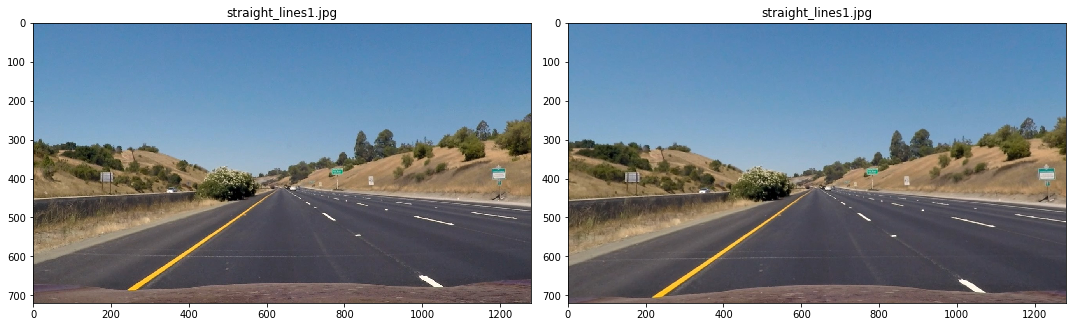

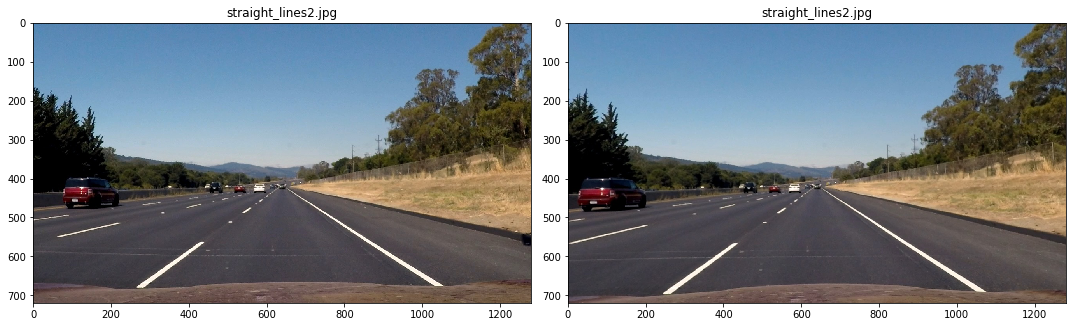

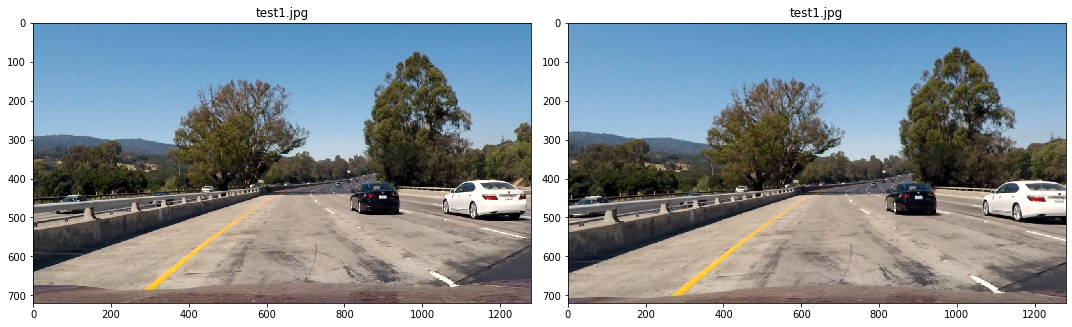

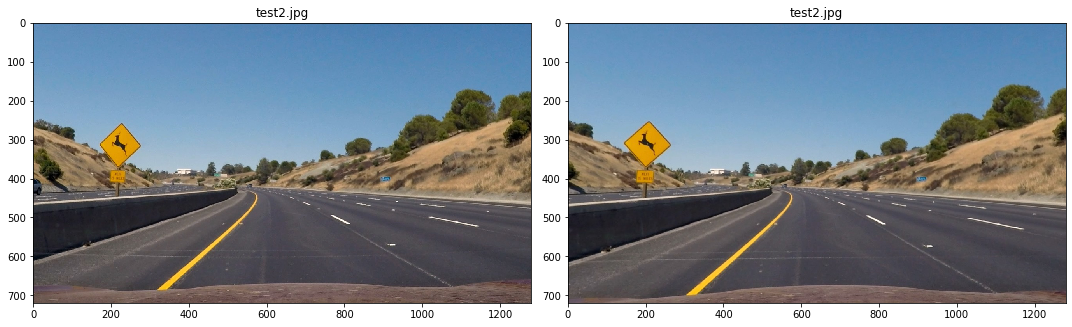

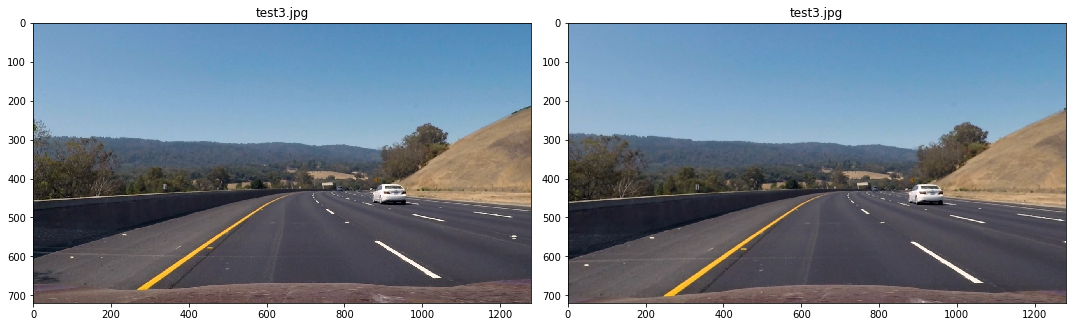

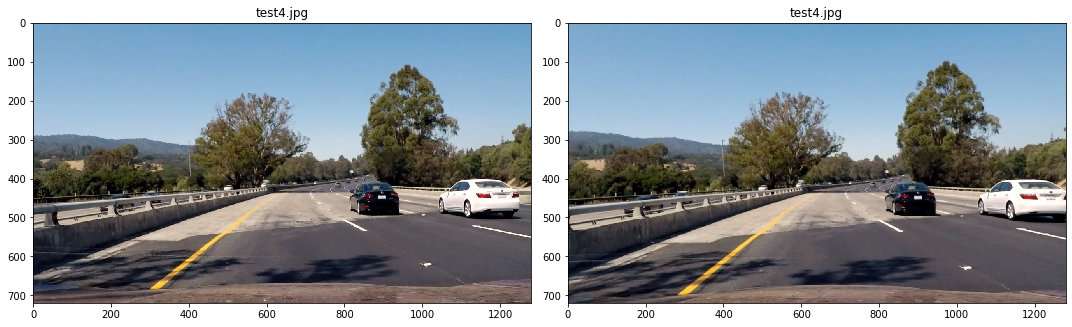

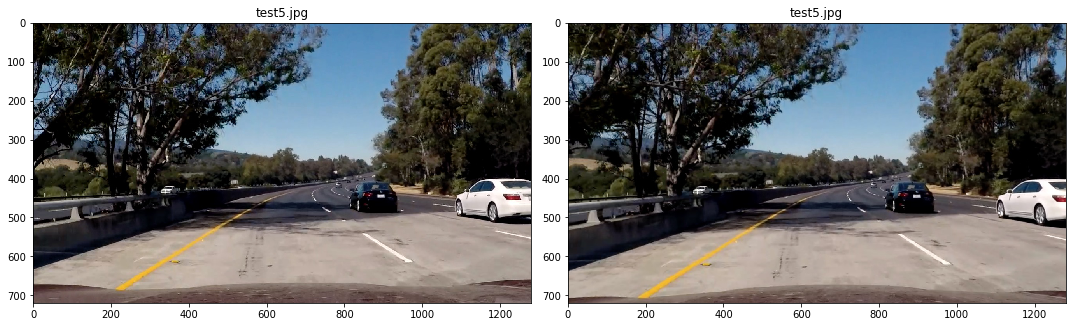

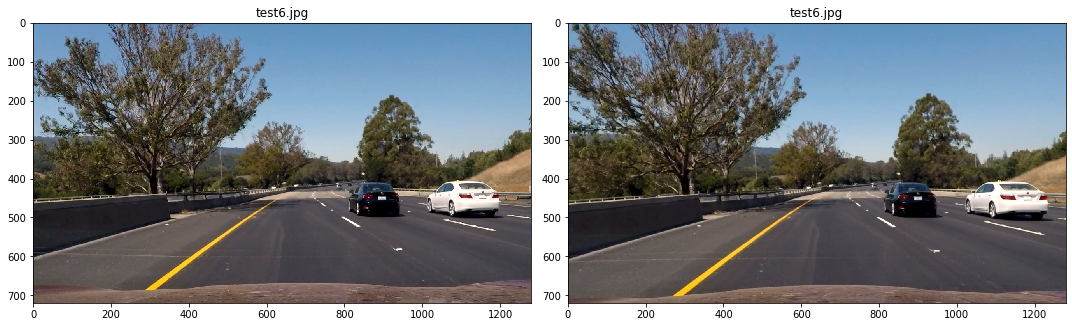

In [6]:
comparison = list(zip(imgs,imgs_undistorted))

for i,imgs in enumerate(comparison):
    name = imgs_name[i]
    display_image(imgs,img_name = [name,name],cols =2)

## Lane Detection: Helper Functions

These following functions will be used to detect lane lines on the road: <br><br>
`convert_gray():` Converting to grayscale <br>
`convert_hls():` Converting to HLS color space <br>
`Sobelx():` Applying Sobel in the **x** direction <br>
`separateChannel():` Returning a specified range of a single channel <br>
`combine_binary():` Combining 2 binary images together <br>

In [72]:
def convert_gray(img):
    """
    returns a gray image
    
    input:  image as an array read using mpimg.imread()
            use the following if read using cv2.imread()
            "return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)"
            
    output: converted gray img 
    """
    
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
def convert_hls(img):
    """
    returns an image in HLS Color Space
    
    input:  image as an array read using mpimg.imread()
            use the following if read using cv2.imread()
            "return cv2.cvtColor(img,cv2.COLOR_BGR2HLS)"
            
    output: converted img in HLS Color Space
    """
    
    return cv2.cvtColor(img,cv2.COLOR_RGB2HLS)

def convert_hsv(img):
    """
    returns an image in HLS Color Space
    
    input:  image as an array read using mpimg.imread()
            use the following if read using cv2.imread()
            "return cv2.cvtColor(img,cv2.COLOR_BGR2HSV)"
            
    output: converted img in HLS Color Space
    """
    
    return cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

def separateChannel(img,channel = 2,thresh = [190,255]):
    """
    returns a specified range in a single channel of an image
    
    input: an image in any Color Space.
    
    output: a specified range in a single channel of an image
    """
    
    channel = img[:,:,channel]
    
    sbinary = np.zeros_like(channel)
    sbinary[(channel>=thresh[0]) & (channel<=thresh[1])] = 1
    
    return sbinary


def combine_colorSpace(img1,img2):
    
    combined_color = np.zeros_like(img1)
    combined_color[(img1==1) | (img2==1)] = 1
    
    return combined_color
    
    
def abs_sobel_thresh(img, ksize=3, thresh=(20,100)):
    """
    returns a derivative of an image in a specified direction
    through Sobel Filtering
    
    input: image as an array read using mpimg.imread() or cv2.imread()
    
    output: image derivate as an array
    
    """
    gray = convert_gray(img)

    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=ksize)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=ksize)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    sbinary = np.zeros_like(scaled_sobelx)
    sbinary[(scaled_sobelx>=thresh[0]) & (scaled_sobelx<thresh[1]) &
            (scaled_sobely>=thresh[0]) & (scaled_sobely<thresh[1])] = 1
    
    return sbinary

def mag_sobel_thresh(img,ksize=9,thresh= (60,100)):
    """
    returns a derivative of an image in a specified direction
    through Sobel Filtering
    
    input: image as an array read using mpimg.imread() or cv2.imread()
    
    output: image derivate as an array
    
    """
    
    gray = convert_gray(img)

    Sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=ksize)
    Sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=ksize)
    
    abs_sobelxy = np.sqrt(Sobelx**2+Sobely**2)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])] = 1  
    
    return mag_binary

def dir_sobel_thresh(img,ksize=15,thresh= (0.7,1.3)):
    """
    returns a derivative of an image in a specified direction
    through Sobel Filtering
    
    input: image as an array read using mpimg.imread() or cv2.imread()
    
    output: image derivate as an array
    
    """
    
    gray = convert_gray(img)

    Sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=ksize)
    Sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=ksize)
    
    abs_sobelx = np.absolute(Sobelx)
    abs_sobely = np.absolute(Sobely)
    
    direction = np.arctan2(abs_sobely,abs_sobelx)

    sbinary = np.zeros_like(direction)
    sbinary[(direction>=thresh[0]) & (direction<=thresh[1])] = 1  
    
    return sbinary

def combine_sobel(abs_binary,mag_binary,dir_binary):
    """
    returns a combined binary of 2 binary images
    
    input: binary images in 0's and 1's 
    
    output: combined/overlaped binary images
    """
    
    combined_binary = np.zeros_like(abs_binary)
    combined_binary[(abs_binary==1) | ((mag_binary==1) & (dir_binary==1))] = 1
    
    return combined_binary

## Testing images

Testing images from the directory `\test_images` before applying the pipeline.

In [73]:
imgs_hls = list(map(lambda img:separateChannel(convert_hls(img)),imgs_undistorted)) 
imgs_hsv = list(map(lambda img:separateChannel(convert_hsv(img), thresh = (220,255)),imgs_undistorted))

colorSpace_combined = list(map(lambda img1,img2:combine_colorSpace(img1,img2),imgs_hls,imgs_hsv))

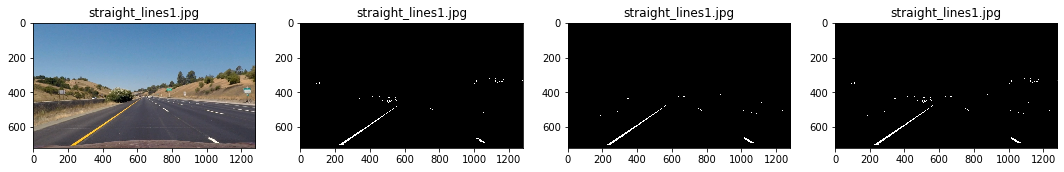

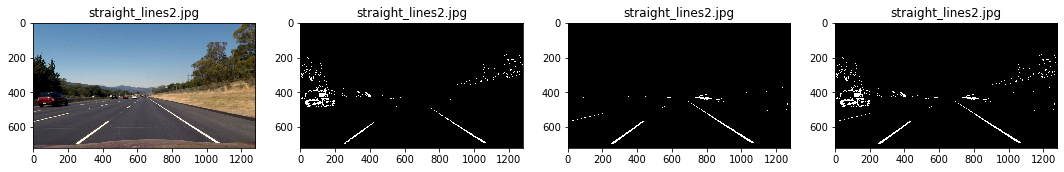

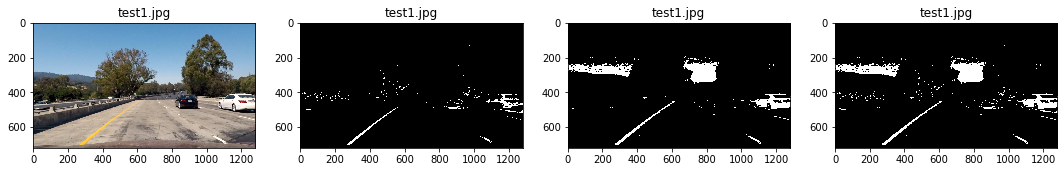

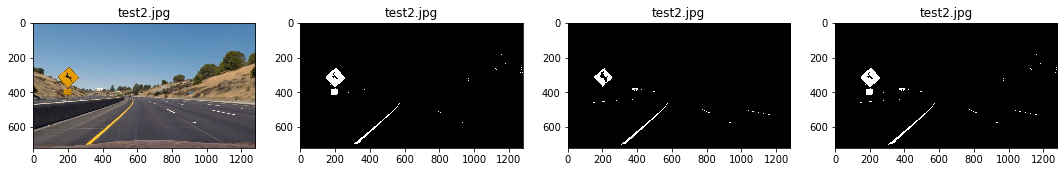

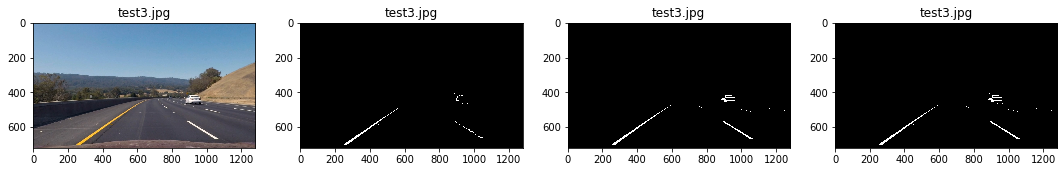

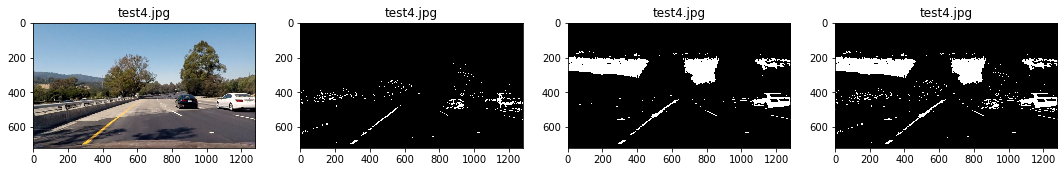

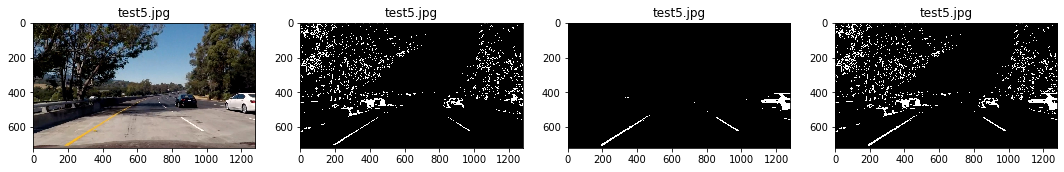

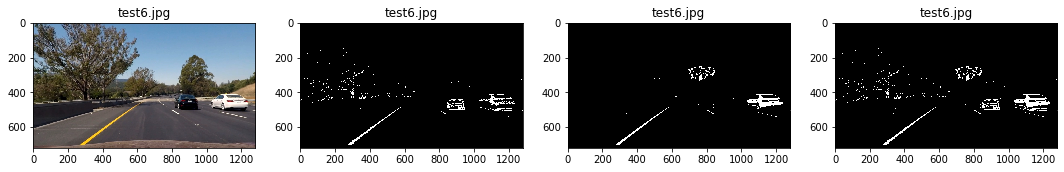

In [74]:
color_space = list(zip(imgs_undistorted,imgs_hls,imgs_hsv,colorSpace_combined))

for i,imgs in enumerate(color_space):
    name = imgs_name[i]
    display_image(imgs,img_name = [name,name,name,name],cols = 4 )

In [75]:
imgs_abs_sobel = list(map(lambda img:abs_sobel_thresh(img),imgs_undistorted))
imgs_mag_sobel = list(map(lambda img:mag_sobel_thresh(img),imgs_undistorted))
imgs_dir_sobel = list(map(lambda img:dir_sobel_thresh(img),imgs_undistorted))

sobel_combined = list(map(lambda aS,mS,dS:combine_sobel(aS,mS,dS),imgs_abs_sobel,imgs_mag_sobel,imgs_dir_sobel))

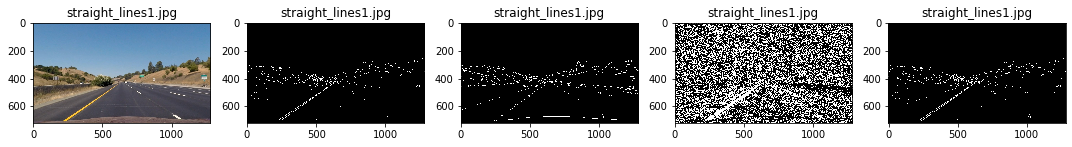

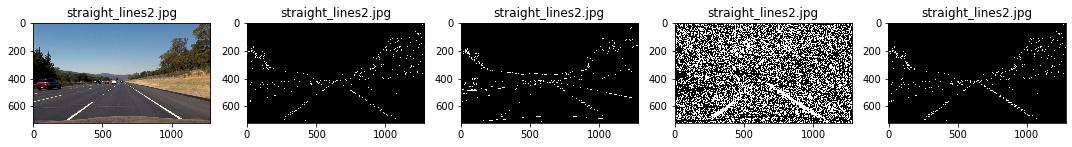

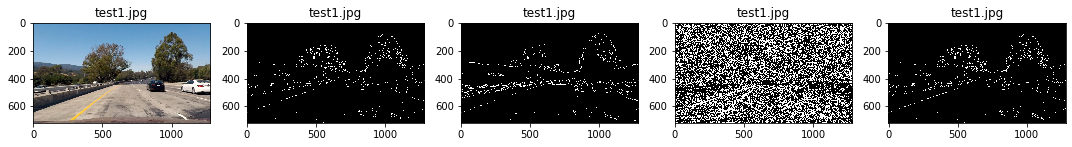

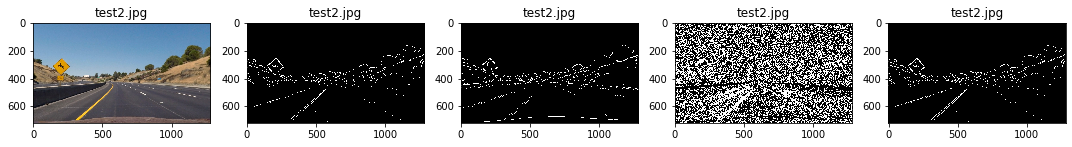

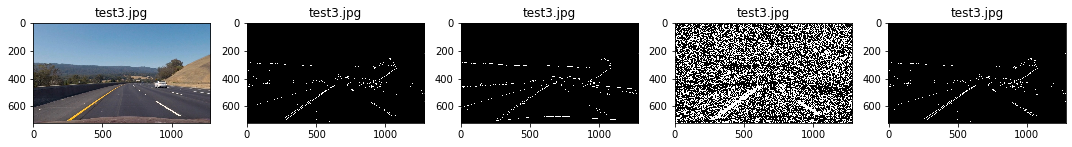

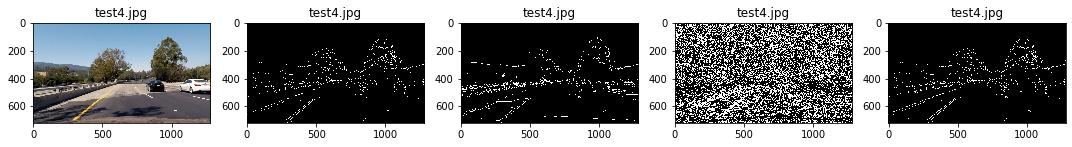

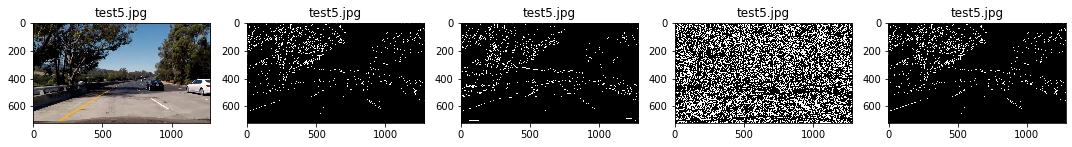

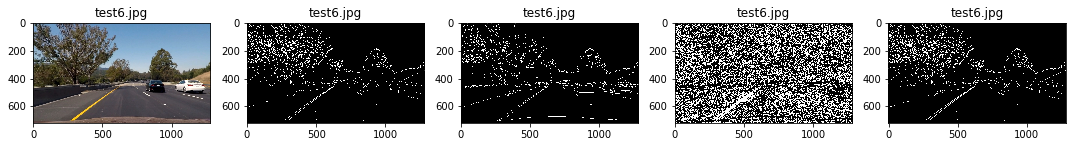

In [76]:
sobel_images = list(zip(imgs_undistorted,imgs_abs_sobel,imgs_mag_sobel,imgs_dir_sobel,sobel_combined))

for i,imgs in enumerate(sobel_images):
    name = imgs_name[i]
    display_image(imgs,img_name = [name,name,name,name,name],cols = 5 )

In [77]:
def combine_binary(binary1,binary2):
    
    binaryImg = np.zeros_like(binary1)
    binaryImg[(binary1==1) | (binary2==1)] = 1
    
    return binaryImg

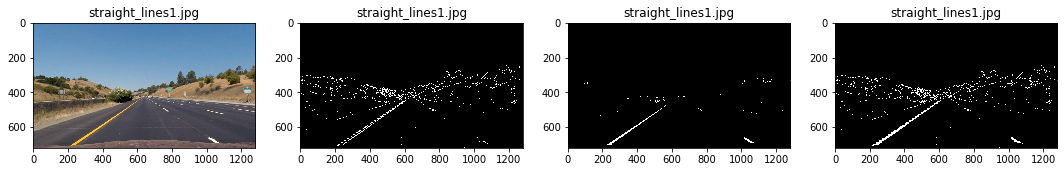

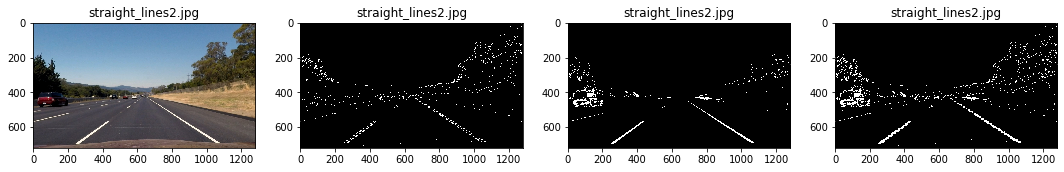

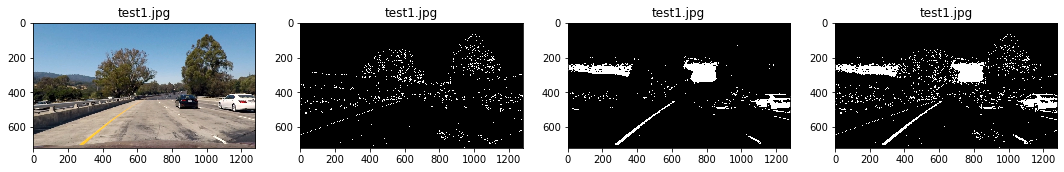

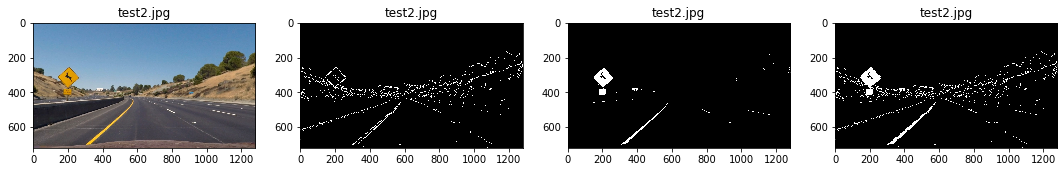

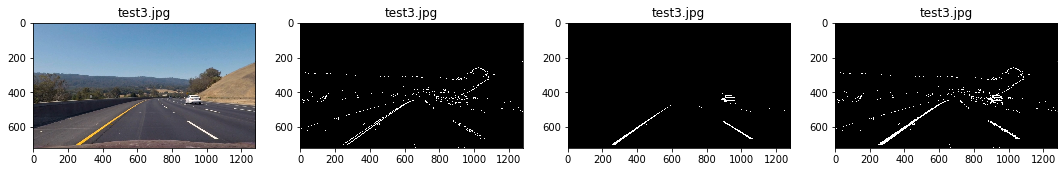

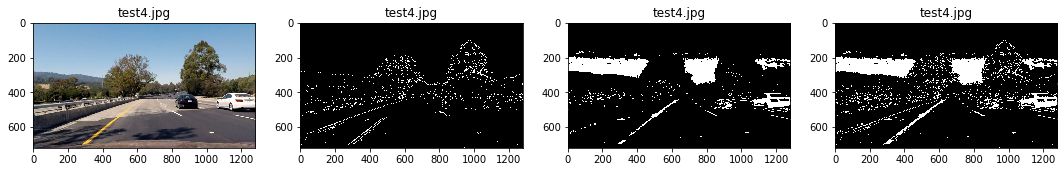

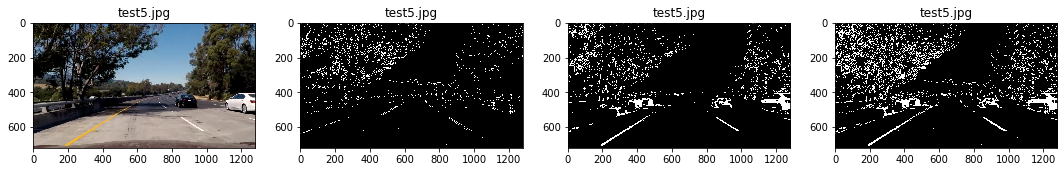

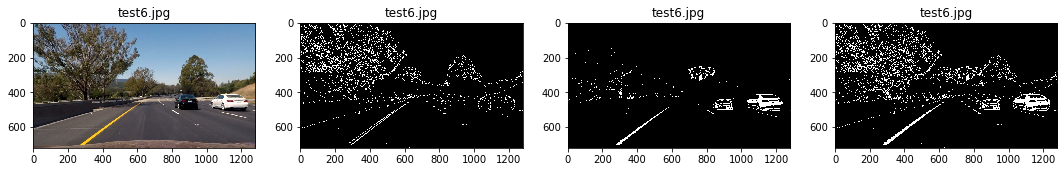

In [78]:
binary_combined = list(map(lambda b1,b2:combine_binary(b1,b2),sobel_combined,colorSpace_combined))

final_comparison = list(zip(imgs_undistorted,sobel_combined,colorSpace_combined,binary_combined))

for i,imgs in enumerate(final_comparison):
    name = imgs_name[i]
    display_image(imgs,img_name = [name,name,name,name],cols = 4 )

## Perspective Transform

In [79]:
def roi(img):
    
    height = img.shape[0]
    width  = img.shape[1]
    
    corner1 = [[int(45/100*width),int(64/100*height)]]
    corner2 = [[int(55/100*width),int(64/100*height)]]
    
    corner3 = [[int(14/100*width),height]]
    corner4 = [[int(86/100*width),height]]
    
    roi = np.array([corner1,corner2,corner3,corner4],dtype =np.float32)
    
    return roi 

def transformation_matrix(img):
    
    src = roi(img)
    
    img_size = (img.shape[1],img.shape[0])
    
    offset = 300
    x1 = offset
    x2 = img_size[0]-offset
    
    y1 = 0
    y2 = img_size[1]
    
    corner1 = [[x1,y1]]
    corner2 = [[x2,y1]]
    corner3 = [[x1,y2]]
    corner4 = [[x2,y2]]

    des = np.array([corner1,corner2,corner3,corner4],dtype=np.float32)
    M = cv2.getPerspectiveTransform(src,des)
    Minv = cv2.getPerspectiveTransform(des,src)
    
    return M , Minv
    
def warp(img,Matrix):
    
    img_size = (img.shape[1],img.shape[0])
    
    return cv2.warpPerspective(img,Matrix,img_size)

In [80]:
M,Minv = transformation_matrix(imgs_undistorted[0])

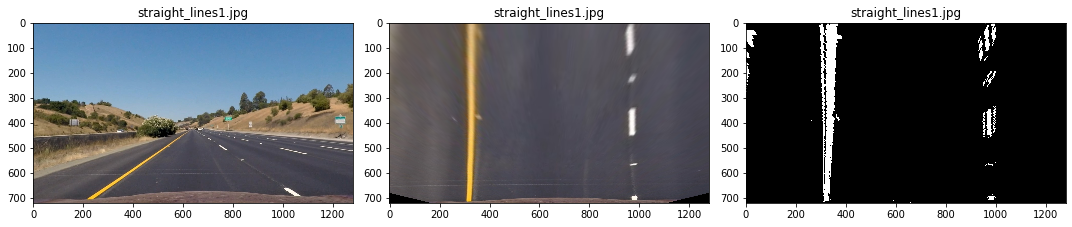

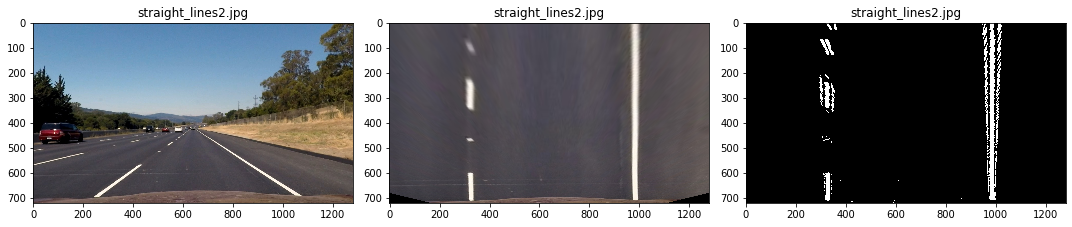

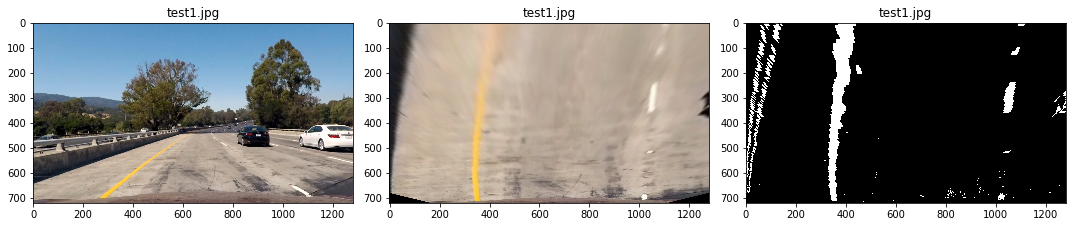

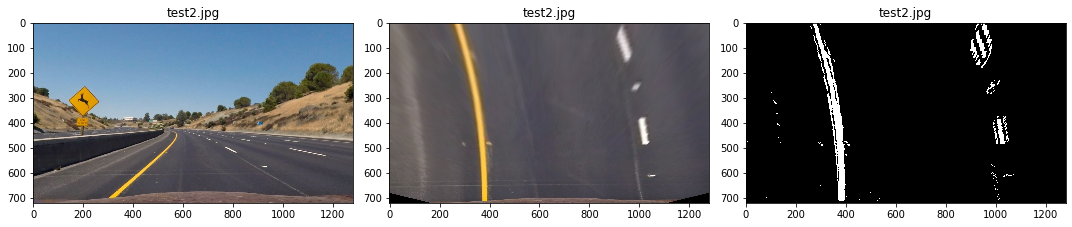

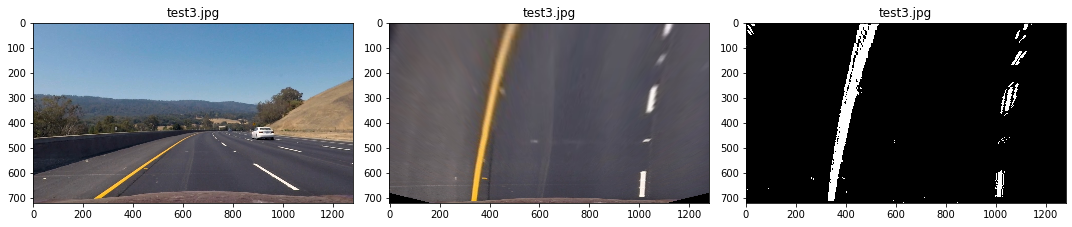

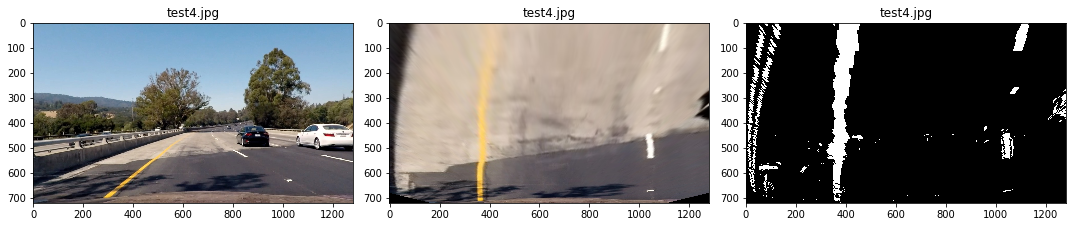

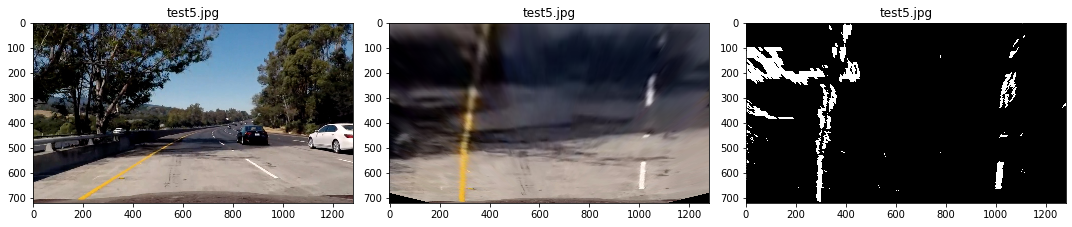

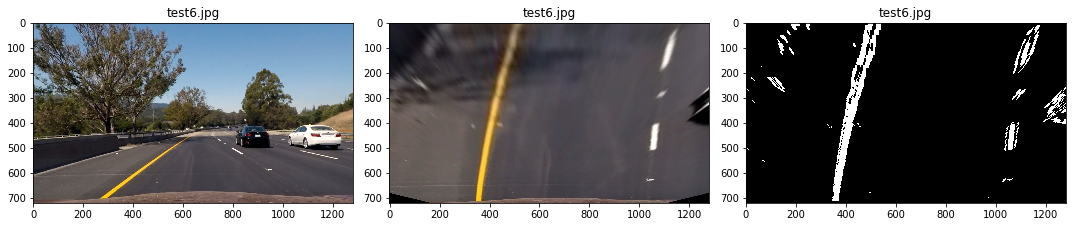

In [81]:
imgs_warped = list(map(lambda imgs:warp(imgs,M),imgs_undistorted))
binary_warped = list(map(lambda imgs: warp(imgs,M),binary_combined))

warped = list(zip(imgs_undistorted,imgs_warped,binary_warped))

for i,imgs in enumerate(warped):
    name = imgs_name[i]
    display_image(imgs,img_name = [name,name,name],cols = 3)

## Sliding Window algorithm

In [82]:
def starting_base(img):
    
    histogram = np.sum(img[int(img.shape[0]//1.5):,:], axis = 0 )
    midpoint = np.int(histogram.shape[0]//2)
    
    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return left_base, right_base 
    
def sliding_window(img, nwindows = 21, margin = 100, minpix = 80):
    
    out_img = np.dstack((img, img, img))*255
    
    window_height = np.int(img.shape[0]//nwindows)
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx_current, rightx_current = starting_base(img)
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        
        y_low = img.shape[0] - (window+1)*window_height
        y_high = img.shape[0] - window*window_height
        
        xleft_low = leftx_current - margin
        xleft_high = leftx_current + margin
        xright_low =rightx_current - margin 
        xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(xleft_low,y_low),(xleft_high,y_high),(0,255,0),2)
        cv2.rectangle(out_img,(xright_low,y_low),(xright_high,y_high),(0,255,0),2)
        
        good_left_inds = ((nonzeroy>=y_low) & (nonzeroy<y_high) &
                          (nonzerox>=xleft_low) & (nonzerox<xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy>=y_low) & (nonzeroy<y_high) &
                           (nonzerox>=xright_low) & (nonzerox<xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds)>minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img 
        
def fit_polynomial(img):
    
    leftx, lefty, rightx, righty, out_img = sliding_window(img)

    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ##Visualization
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img


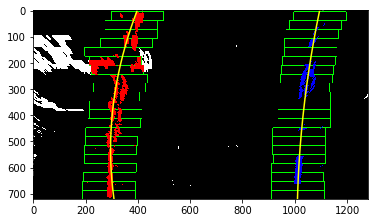

In [84]:
plt.imshow(fit_polynomial(binary_warped[6]))

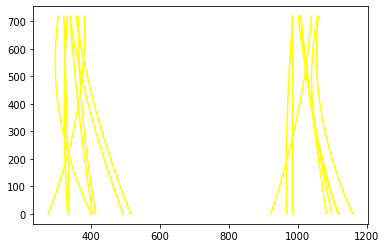

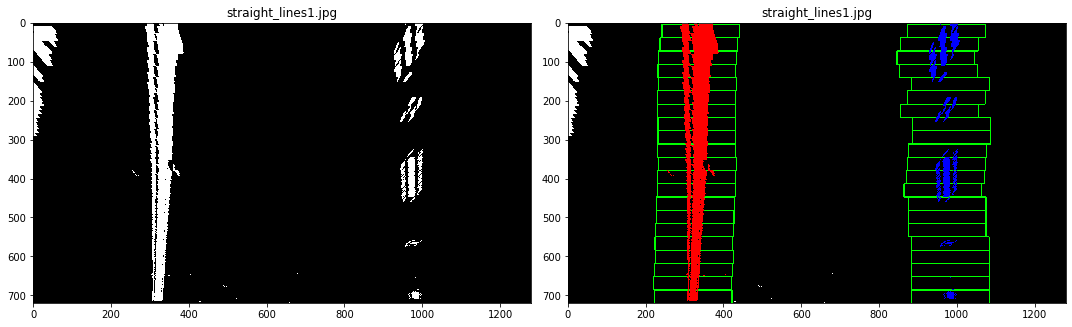

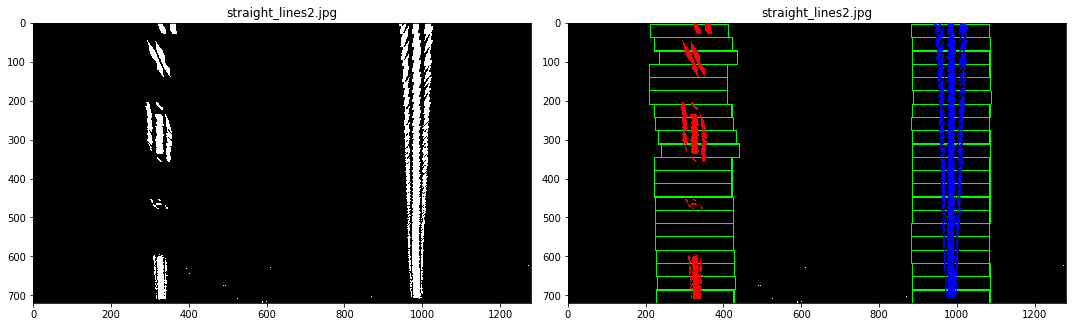

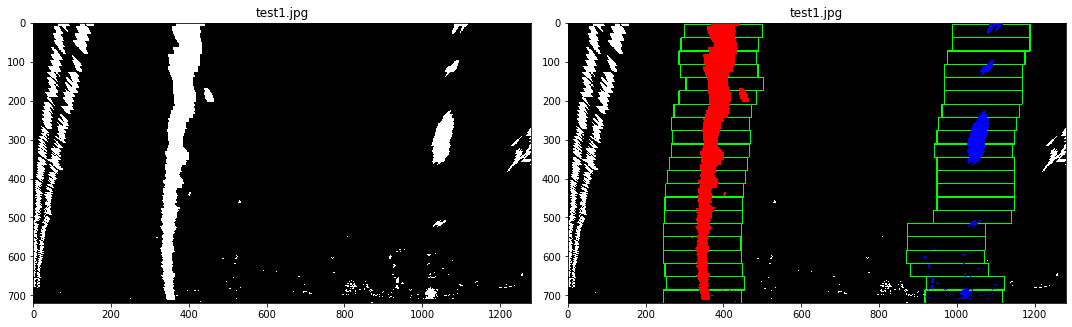

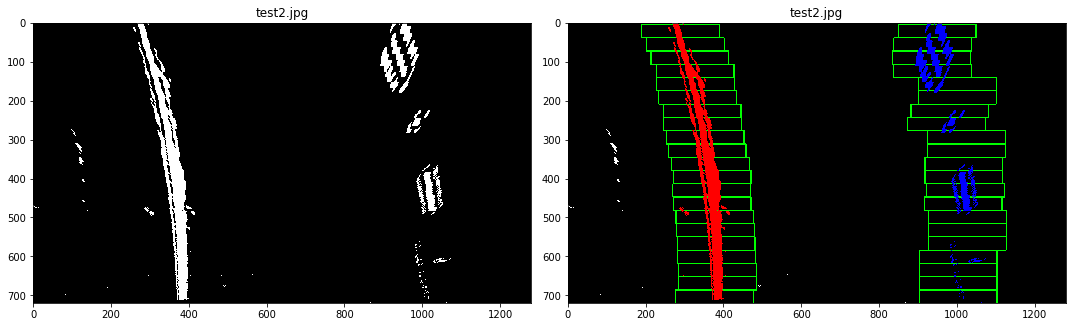

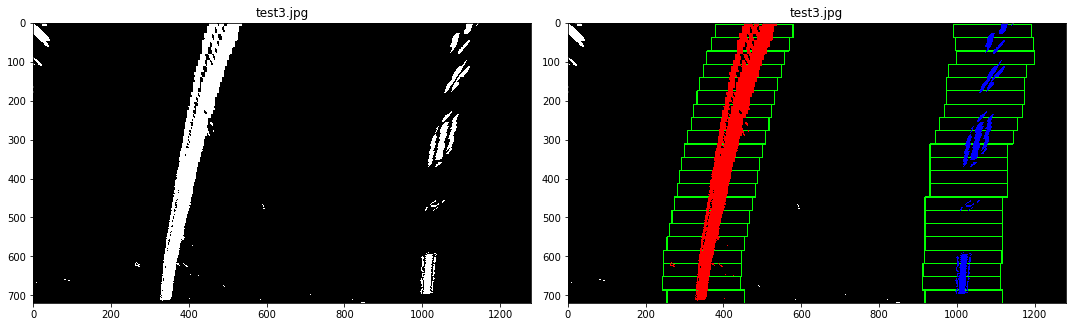

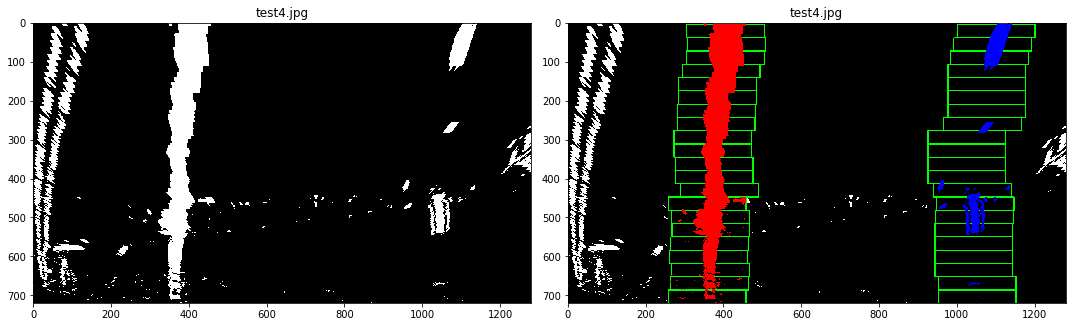

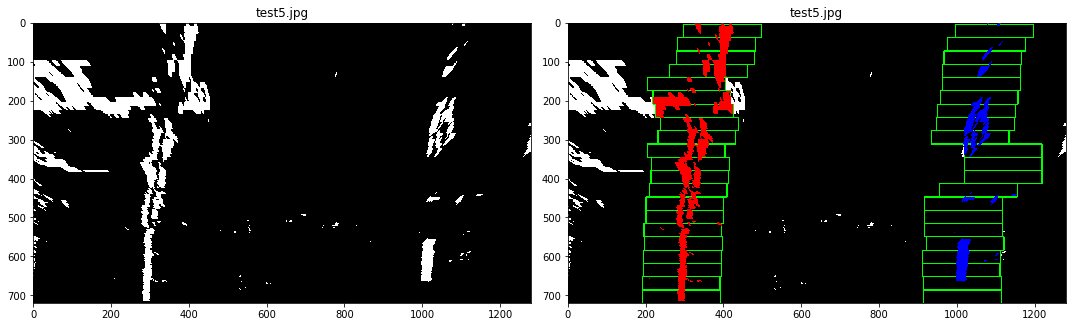

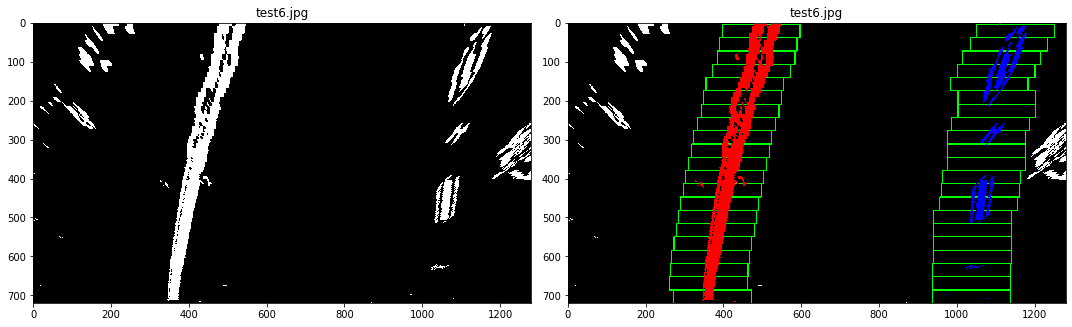

In [65]:
poly_fit = list(map(lambda img: fit_polynomial(img),binary_warped))

poly = list(zip(binary_warped,poly_fit))

for i,imgs in enumerate(poly):
    name = imgs_name[i]
    display_image(imgs,img_name = [name,name],cols = 2)